<a href="https://colab.research.google.com/github/Martine1grace/NLP_FELLOWSHIP_AI-Machine_Translation.-/blob/main/BasicRegression_Tensorflow/Tensorflow%2Ckeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.9.2


In [3]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [4]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [5]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [6]:
dataset = dataset.dropna()

In [7]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [8]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [9]:
# dataset = pd.get_dummies(dataset,columnss=['Origin'],prefix='',prefix_sep='')
# dataset.tail()

In [52]:
dataset = pd.get_dummies(dataset, columns=['Weight'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Acceleration,Model Year,Europe,Japan,USA,1613.0,...,4699.0,4732.0,4735.0,4746.0,4906.0,4951.0,4952.0,4955.0,4997.0,5140.0
393,27.0,4,140.0,86.0,15.6,82,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
394,44.0,4,97.0,52.0,24.6,82,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
395,32.0,4,135.0,84.0,11.6,82,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
396,28.0,4,120.0,79.0,18.6,82,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
397,31.0,4,119.0,82.0,19.4,82,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


Split the data into training and test sets

In [10]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

Review the joint distribution of a few pairs of columns from the training set.

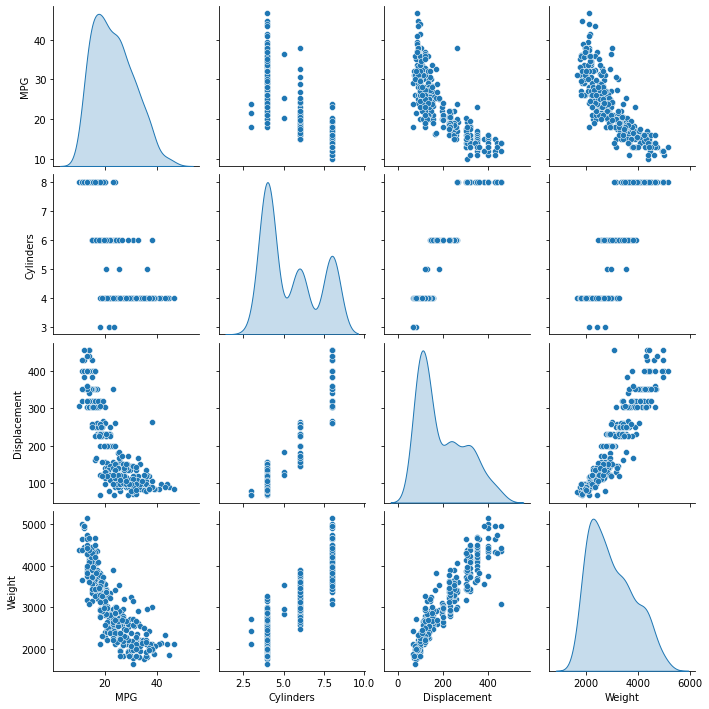

In [12]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [13]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [14]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

Normalization

In the table of statistics it's easy to see how different the ranges of each feature are:

In [15]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


In [17]:
#add feature normalization in your model
normalizer = tf.keras.layers.Normalization(axis=-1)

In [18]:
#Then, fit the state of the preprocessing layer to the data
normalizer.adapt(np.array(train_features))

In [19]:
#Calculate the mean and variance, and store them in the layer:
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


In [20]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())
  

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


Linear regression

Linear regression with one variable

In [22]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)
#The number of inputs can either be set by the input_shape argument,
# or automatically when the model is run for the first time.

In [23]:
#Build the Keras Sequential model:

horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [24]:
#This model will predict 'MPG' from 'Horsepower'
horsepower_model.predict(horsepower[:10])


1/1 [==============================] - 2s 2s/step


array([[-1.323],
       [-0.747],
       [ 2.442],
       [-1.855],
       [-1.678],
       [-0.659],
       [-1.988],
       [-1.678],
       [-0.437],
       [-0.747]], dtype=float32)

In [35]:
horsepower_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.2),
    loss='mean_absolute_error')

In [36]:
#Use Keras Model.fit to execute the training for 100 epochs:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 4.05 s, sys: 316 ms, total: 4.37 s
Wall time: 3.71 s


Visualize the model's training progress using the stats stored in the history object:

In [37]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.815355,4.264538,95
96,3.809134,4.197783,96
97,3.816144,4.119664,97
98,3.810840,4.135906,98
99,3.808708,4.231002,99


In [58]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

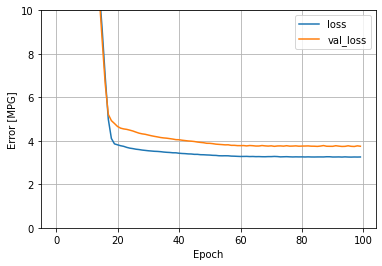

In [59]:
plot_loss(history)

Collect the results on the test set for later:

In [60]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

Since this is a single variable regression, it's easy to view the model's predictions as a function of the input:

In [61]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)


8/8 [==============================] - 0s 2ms/step


In [62]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

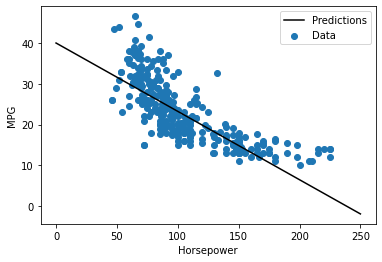

In [63]:
plot_horsepower(x, y)

Linear regression with multiple inputs

In [64]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])


In [65]:
linear_model.predict(train_features[:10])

1/1 [==============================] - 0s 36ms/step


array([[ 0.361],
       [ 0.083],
       [ 0.172],
       [-0.198],
       [-1.411],
       [-0.281],
       [-1.501],
       [ 0.844],
       [-0.027],
       [-0.925]], dtype=float32)

When you call the model, its weight matrices will be built—check that the kernel weights (the  in Y=mx+b ) have a shape of (9, 1):

In [66]:
linear_model.layers[1].kernel


<tf.Variable 'dense_5/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.525],
       [ 0.149],
       [ 0.068],
       [ 0.122],
       [-0.14 ],
       [-0.252],
       [ 0.182],
       [-0.693],
       [-0.27 ]], dtype=float32)>

In [67]:
#Configure the model with Keras Model.compile and train with Model.fit for 100 epochs:

linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [68]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 3.93 s, sys: 317 ms, total: 4.24 s
Wall time: 5.38 s


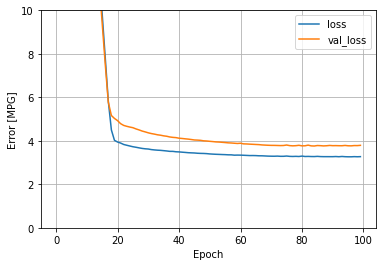

In [81]:
plot_loss(history)


In [82]:
#Collect the results on the test set for later:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

In [83]:
test_results['linear_model']

2.4933900833129883

Regression with a deep neural network (DNN)

In [71]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [72]:
#regression DNN and single input
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

In [73]:
dnn_horsepower_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_6 (Dense)             (None, 64)                128       
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [74]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 4.13 s, sys: 343 ms, total: 4.47 s
Wall time: 3.88 s


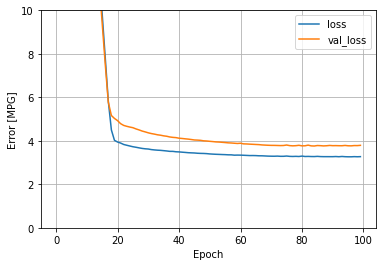

In [75]:
plot_loss(history)

If you plot the predictions as a function of 'Horsepower', you should notice how this model takes advantage of the nonlinearity provided by the hidden layers:

In [76]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)


8/8 [==============================] - 0s 2ms/step


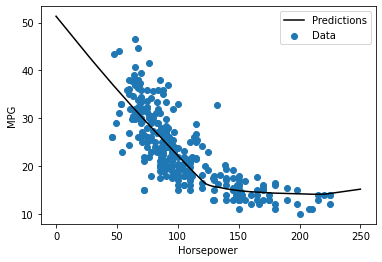

In [77]:
plot_horsepower(x, y)

Collect the results on the test set for later:

In [78]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

In [79]:
test_results['dnn_horsepower_model']

2.9388277530670166

Regression using a DNN and multiple inputs

In [84]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 9)                19        
 ion)                                                            
                                                                 
 dense_9 (Dense)             (None, 64)                640       
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [85]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 4.18 s, sys: 385 ms, total: 4.56 s
Wall time: 3.96 s


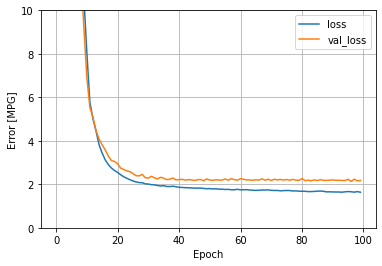

In [86]:
plot_loss(history)

In [87]:
#Collect the results on the test set:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

Performance

In [88]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.685082
linear_model,2.493390
dnn_horsepower_model,2.938828
dnn_model,1.692075


3/3 [==============================] - 0s 3ms/step


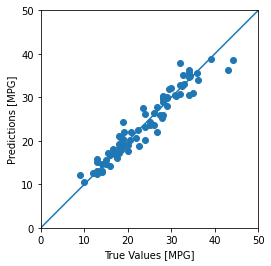

In [89]:
#Make predictions on dnn_model
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


It appears that the model predicts reasonably well.

Now, check the error distribution:

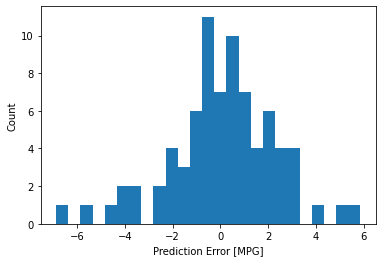

In [90]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')


In [91]:
dnn_model.save('dnn_model')


In [92]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [93]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.685082
linear_model,2.493390
dnn_horsepower_model,2.938828
dnn_model,1.692075
reloaded,1.692075
